In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
import seaborn as sns
from matplotlib import pyplot as plt
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ds-nigeria-2019-challenge-insurance-prediction/sample_submission.csv
/kaggle/input/ds-nigeria-2019-challenge-insurance-prediction/train_data.csv
/kaggle/input/ds-nigeria-2019-challenge-insurance-prediction/test_data.csv
/kaggle/input/ds-nigeria-2019-challenge-insurance-prediction/VariableDescription.csv


In [2]:
df = pd.read_csv('/kaggle/input/ds-nigeria-2019-challenge-insurance-prediction/train_data.csv')

df.head().T

,0,1,2,3,4
Customer Id,H14663,H2037,H3802,H3834,H5053
YearOfObservation,2013,2015,2014,2013,2014
Insured_Period,1,1,1,1,1
Residential,0,0,0,0,0
Building_Painted,N,V,N,V,V
Building_Fenced,V,N,V,V,N
Garden,V,O,V,V,O
Settlement,U,R,U,U,R
Building Dimension,290,490,595,2840,680
Building_Type,1,1,1,1,1


In [3]:
print(str(df['Claim'].value_counts()[0]) + ' is', round(df['Claim'].value_counts()[0]/len(df) * 100,2),'% of dataset')
print(str(df['Claim'].value_counts()[1]) + ' is', round(df['Claim'].value_counts()[1]/len(df) * 100,2),'% of dataset')

5526 is 77.18 % of dataset
1634 is 22.82 % of dataset


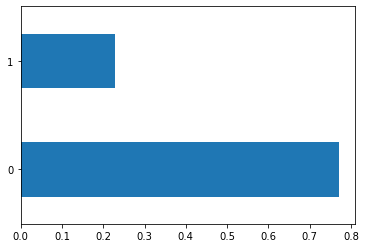

In [4]:
df['Claim'].value_counts(normalize=True).plot(kind='barh')

#Классы распределены неравномерно

In [5]:
desc = pd.read_csv('/kaggle/input/ds-nigeria-2019-challenge-insurance-prediction/VariableDescription.csv')
desc

,Variable,Description
0,Customer Id,Identification number for the Policy holder
1,YearOfObservation,year of observation for the insured policy
2,Insured_Period,duration of insurance policy in Olusola Insura...
3,Residential,is the building a residential building or not
4,Building_Painted,"is the building painted or not (N-Painted, V-N..."
5,Building_Fenced,"is the building fence or not (N-Fenced, V-Not ..."
6,Garden,building has garden or not (V-has garden; O-no...
7,Settlement,Area where the building is located. (R- rural ...
8,Building Dimension,Size of the insured building in m2
9,Building_Type,"The type of building (Type 1, 2, 3, 4)"


In [6]:
#customer id is useless for prediction, so we'll drop it
df = df.drop(columns=['Customer Id'])


In [7]:
#let's deal with missing values
#nan in building dimension
#missing values in number of windows
df['NumberOfWindows'].unique()


array(['   .', '4', '3', '2', '5', '>=10', '6', '7', '9', '8', '1'],
      dtype=object)

In [8]:
df['NumberOfWindows'].value_counts()
#Assuming that ' .' is the most common number of windows. Also let '>=10' equal 10

   .    3551
4        939
3        844
5        639
2        363
6        306
7        211
8        116
1         75
>=10      67
9         49
Name: NumberOfWindows, dtype: int64

In [9]:
df['NumberOfWindows'] = df['NumberOfWindows'].replace('   .',4)
df['NumberOfWindows'] = df['NumberOfWindows'].replace('>=10',10)


In [10]:
df['NumberOfWindows']  = df['NumberOfWindows'].astype('int64')

In [11]:
df['Building Dimension'].isna().sum()
#lets replace them with mode

106

In [12]:
df['Building Dimension'].value_counts()

400.0     150
500.0     120
300.0     118
450.0     117
600.0     114
         ... 
211.0       1
3324.0      1
1228.0      1
3762.0      1
1734.0      1
Name: Building Dimension, Length: 2043, dtype: int64

In [13]:
df['Building Dimension'] = df['Building Dimension'].replace(np.nan,400)

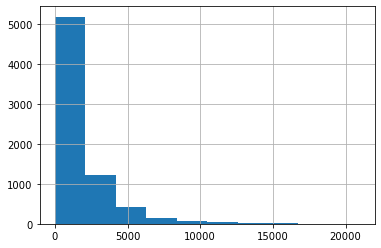

In [14]:
df['Building Dimension'].hist(bins = 10)

In [15]:
#We should deal with other data to be able to analyse correlation beetwen features and target
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7160 entries, 0 to 7159
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   YearOfObservation   7160 non-null   int64  
 1   Insured_Period      7160 non-null   float64
 2   Residential         7160 non-null   int64  
 3   Building_Painted    7160 non-null   object 
 4   Building_Fenced     7160 non-null   object 
 5   Garden              7153 non-null   object 
 6   Settlement          7160 non-null   object 
 7   Building Dimension  7160 non-null   float64
 8   Building_Type       7160 non-null   int64  
 9   Date_of_Occupancy   6652 non-null   float64
 10  NumberOfWindows     7160 non-null   int64  
 11  Geo_Code            7058 non-null   object 
 12  Claim               7160 non-null   int64  
dtypes: float64(3), int64(5), object(5)
memory usage: 727.3+ KB


In [16]:
df['Garden'].mode()

0    O
dtype: object

In [17]:
df['Garden'].unique()
df['Garden'] = df['Garden'].replace(np.nan, 'V')

In [18]:
df['Date_of_Occupancy'].unique()
df['Date_of_Occupancy'].mode()
df['Date_of_Occupancy'] = df['Date_of_Occupancy'].replace(np.nan, 1960)

In [19]:
df['Geo_Code'].unique()
df['Geo_Code'].mode()
df['Geo_Code'] = df['Geo_Code'].replace(np.nan, '6088')

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7160 entries, 0 to 7159
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   YearOfObservation   7160 non-null   int64  
 1   Insured_Period      7160 non-null   float64
 2   Residential         7160 non-null   int64  
 3   Building_Painted    7160 non-null   object 
 4   Building_Fenced     7160 non-null   object 
 5   Garden              7160 non-null   object 
 6   Settlement          7160 non-null   object 
 7   Building Dimension  7160 non-null   float64
 8   Building_Type       7160 non-null   int64  
 9   Date_of_Occupancy   7160 non-null   float64
 10  NumberOfWindows     7160 non-null   int64  
 11  Geo_Code            7160 non-null   object 
 12  Claim               7160 non-null   int64  
dtypes: float64(3), int64(5), object(5)
memory usage: 727.3+ KB


In [21]:
df.corr(method='spearman')

,YearOfObservation,Insured_Period,Residential,Building Dimension,Building_Type,Date_of_Occupancy,NumberOfWindows,Claim
YearOfObservation,1.000000,-0.214766,-0.040820,0.036287,0.005712,0.003649,0.006004,-0.013598
Insured_Period,-0.214766,1.000000,-0.034902,0.023811,-0.002997,0.013839,0.008205,0.074373
Residential,-0.040820,-0.034902,1.000000,0.063040,0.327858,-0.069762,0.115584,0.063509
Building Dimension,0.036287,0.023811,0.063040,1.000000,-0.008587,0.353868,0.348720,0.284506
Building_Type,0.005712,-0.002997,0.327858,-0.008587,1.000000,-0.217915,0.174896,0.106516
Date_of_Occupancy,0.003649,0.013839,-0.069762,0.353868,-0.217915,1.000000,-0.059156,0.023101
NumberOfWindows,0.006004,0.008205,0.115584,0.348720,0.174896,-0.059156,1.000000,0.171211
Claim,-0.013598,0.074373,0.063509,0.284506,0.106516,0.023101,0.171211,1.000000


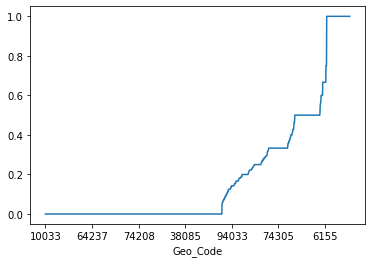

In [22]:
df.groupby(['Geo_Code'])['Claim'].agg('mean').sort_values().plot()

In [23]:
codes = df.groupby(['Geo_Code'])['Claim'].agg('mean').to_dict()

****Наблюдаем сильные скачки, следовательно есть опасные регионы и это было бы неплохо учесть в модели.****

In [24]:
df['Geo_Code'] = df.groupby(['Geo_Code'])['Claim'].transform('mean')

In [25]:
df.corr(method='spearman') #0.39 with target

,YearOfObservation,Insured_Period,Residential,Building Dimension,Building_Type,Date_of_Occupancy,NumberOfWindows,Geo_Code,Claim
YearOfObservation,1.000000,-0.214766,-0.040820,0.036287,0.005712,0.003649,0.006004,0.006840,-0.013598
Insured_Period,-0.214766,1.000000,-0.034902,0.023811,-0.002997,0.013839,0.008205,0.029782,0.074373
Residential,-0.040820,-0.034902,1.000000,0.063040,0.327858,-0.069762,0.115584,0.140618,0.063509
Building Dimension,0.036287,0.023811,0.063040,1.000000,-0.008587,0.353868,0.348720,0.172776,0.284506
Building_Type,0.005712,-0.002997,0.327858,-0.008587,1.000000,-0.217915,0.174896,0.310774,0.106516
Date_of_Occupancy,0.003649,0.013839,-0.069762,0.353868,-0.217915,1.000000,-0.059156,-0.036039,0.023101
NumberOfWindows,0.006004,0.008205,0.115584,0.348720,0.174896,-0.059156,1.000000,0.193940,0.171211
Geo_Code,0.006840,0.029782,0.140618,0.172776,0.310774,-0.036039,0.193940,1.000000,0.397746
Claim,-0.013598,0.074373,0.063509,0.284506,0.106516,0.023101,0.171211,0.397746,1.000000


In [26]:
df['Settlement'].unique()
df['Settlement'] = df['Settlement'].replace("R",1) # Rural (сельская местность) - 1
df['Settlement'] = df['Settlement'].replace("U",0) # Urban - 0

In [27]:
df['Garden'].unique()
df['Garden'] = df['Garden'].replace("V",1) # has garden
df['Garden'] = df['Garden'].replace("O",0) # no garden

In [28]:
df['Building_Fenced'].unique()
df['Building_Fenced'] = df['Building_Fenced'].replace("N",1) # has fence
df['Building_Fenced'] = df['Building_Fenced'].replace("V",0) # no fence

In [29]:
df['Building_Painted'].unique()
df['Building_Painted'] = df['Building_Painted'].replace("N",1) # painted
df['Building_Painted'] = df['Building_Painted'].replace("V",0) # not painted

In [30]:
df.corr(method='spearman')

,YearOfObservation,Insured_Period,Residential,Building_Painted,Building_Fenced,Garden,Settlement,Building Dimension,Building_Type,Date_of_Occupancy,NumberOfWindows,Geo_Code,Claim
YearOfObservation,1.000000,-0.214766,-0.040820,-0.057249,0.120641,-0.121215,0.120415,0.036287,0.005712,0.003649,0.006004,0.006840,-0.013598
Insured_Period,-0.214766,1.000000,-0.034902,0.028167,0.005096,-0.004693,0.004705,0.023811,-0.002997,0.013839,0.008205,0.029782,0.074373
Residential,-0.040820,-0.034902,1.000000,0.032927,0.082448,-0.082952,0.082684,0.063040,0.327858,-0.069762,0.115584,0.140618,0.063509
Building_Painted,-0.057249,0.028167,0.032927,1.000000,-0.574757,0.573787,-0.575081,-0.095273,0.048999,0.025482,-0.014188,-0.014642,-0.029857
Building_Fenced,0.120641,0.005096,0.082448,-0.574757,1.000000,-0.997767,0.999441,0.161786,0.020121,-0.049371,0.028801,0.014890,0.051657
Garden,-0.121215,-0.004693,-0.082952,0.573787,-0.997767,1.000000,-0.997768,-0.161130,-0.022146,0.049842,-0.029460,-0.014132,-0.051902
Settlement,0.120415,0.004705,0.082684,-0.575081,0.999441,-0.997768,1.000000,0.161570,0.020061,-0.049432,0.029346,0.015187,0.052019
Building Dimension,0.036287,0.023811,0.063040,-0.095273,0.161786,-0.161130,0.161570,1.000000,-0.008587,0.353868,0.348720,0.172776,0.284506
Building_Type,0.005712,-0.002997,0.327858,0.048999,0.020121,-0.022146,0.020061,-0.008587,1.000000,-0.217915,0.174896,0.310774,0.106516
Date_of_Occupancy,0.003649,0.013839,-0.069762,0.025482,-0.049371,0.049842,-0.049432,0.353868,-0.217915,1.000000,-0.059156,-0.036039,0.023101


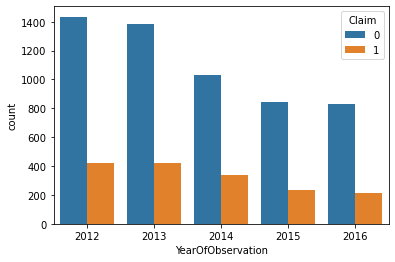

In [31]:
sns.countplot(x='YearOfObservation', data=df, hue='Claim')

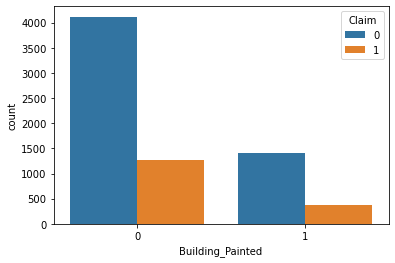

In [32]:
sns.countplot(x='Building_Painted', data=df, hue='Claim')

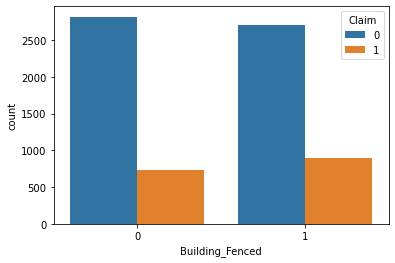

In [33]:
sns.countplot(x='Building_Fenced', data=df, hue='Claim')

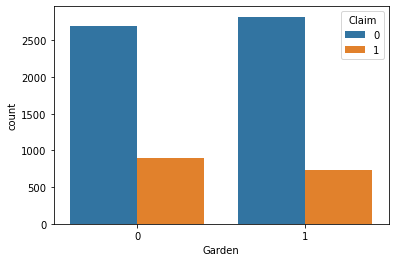

In [34]:
sns.countplot(x='Garden',data=df, hue='Claim')

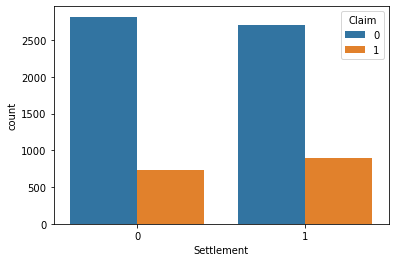

In [35]:
sns.countplot(x='Settlement', data=df, hue='Claim')

In [36]:
df = df.drop(columns=['Garden',
                     'Settlement','Geo_Code'])
df = pd.get_dummies(df, columns=['Building_Type'])
df

,YearOfObservation,Insured_Period,Residential,Building_Painted,Building_Fenced,Building Dimension,Date_of_Occupancy,NumberOfWindows,Claim,Building_Type_1,Building_Type_2,Building_Type_3,Building_Type_4
0,2013,1.000000,0,1,0,290.0,1960.0,4,0,1,0,0,0
1,2015,1.000000,0,0,1,490.0,1850.0,4,0,1,0,0,0
2,2014,1.000000,0,1,0,595.0,1960.0,4,0,1,0,0,0
3,2013,1.000000,0,0,0,2840.0,1960.0,4,0,1,0,0,0
4,2014,1.000000,0,0,1,680.0,1800.0,3,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7155,2012,1.000000,1,0,0,400.0,2001.0,4,0,1,0,0,0
7156,2013,1.000000,0,0,0,400.0,1980.0,4,1,0,1,0,0
7157,2016,0.038251,0,0,0,400.0,1992.0,4,0,1,0,0,0
7158,2013,1.000000,0,0,0,400.0,1972.0,4,0,1,0,0,0


In [37]:
print(str(df['Claim'].value_counts()[0]) + ' is', round(df['Claim'].value_counts()[0]/len(df) * 100,2),'% of dataset')
print(str(df['Claim'].value_counts()[1]) + ' is', round(df['Claim'].value_counts()[1]/len(df) * 100,2),'% of dataset')

5526 is 77.18 % of dataset
1634 is 22.82 % of dataset


In [38]:
df['YearOfObservation'] = 2020-df['YearOfObservation']
df['Date_of_Occupancy'] = 2020-df['Date_of_Occupancy']
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7160 entries, 0 to 7159
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   YearOfObservation   7160 non-null   int64  
 1   Insured_Period      7160 non-null   float64
 2   Residential         7160 non-null   int64  
 3   Building_Painted    7160 non-null   int64  
 4   Building_Fenced     7160 non-null   int64  
 5   Building Dimension  7160 non-null   float64
 6   Date_of_Occupancy   7160 non-null   float64
 7   NumberOfWindows     7160 non-null   int64  
 8   Claim               7160 non-null   int64  
 9   Building_Type_1     7160 non-null   uint8  
 10  Building_Type_2     7160 non-null   uint8  
 11  Building_Type_3     7160 non-null   uint8  
 12  Building_Type_4     7160 non-null   uint8  
dtypes: float64(3), int64(6), uint8(4)
memory usage: 531.5 KB


In [39]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,accuracy_score,roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

X = df.drop('Claim',axis=1)
y = df['Claim']
X = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=24531)


In [40]:
pca = PCA(.90, whiten = True)
principalComponents = pca.fit_transform(X)


In [41]:
print(pca.explained_variance_ratio_)


[0.15445263 0.13540963 0.12493971 0.11165943 0.09813599 0.08554949
 0.08006698 0.07246769 0.05722105]


In [42]:
lr = LogisticRegression(C = 0.5,max_iter = 3000, class_weight = 'balanced')#class_weight нужен так как классы не сбалансированы, https://towardsdatascience.com/weighted-logistic-regression-for-imbalanced-dataset-9a5cd88e68b
lr.fit(X_train,y_train)
y_pred = lr.predict(X_test)
confusion_matrix(y_test,y_pred)

array([[404, 148],
       [ 78,  86]])

In [43]:
accuracy_score(y_test,y_pred)

0.6843575418994413

In [44]:
precision_score(y_test,y_pred)

0.36752136752136755

In [45]:
f1_score(y_test,y_pred)

0.43216080402010054

In [46]:
roc_auc_score(y_test,y_pred)

0.6281371509367267

In [47]:
recall_score(y_test,y_pred)

0.524390243902439

# Подбор параметров

In [48]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

c_values = np.logspace(-3, 3, 25)

# define hyperparameters
hyperparam_grid = {"penalty": ["l1", "l2"]
                   ,"C": c_values
                   ,"fit_intercept": [True, False]}

In [49]:
# define evaluation procedure
grid = GridSearchCV(lr,hyperparam_grid,scoring="roc_auc", cv=5, n_jobs=-1, refit=True)
grid.fit(X_train,y_train)
print(f'Best score: {grid.best_score_} with param: {grid.best_params_}')

Best score: 0.7171810815668289 with param: {'C': 56.23413251903491, 'fit_intercept': False, 'penalty': 'l2'}


In [50]:
print(grid.best_params_)
print(grid.best_score_)

{'C': 56.23413251903491, 'fit_intercept': False, 'penalty': 'l2'}
0.7171810815668289


In [51]:
lr = LogisticRegression(C = 56.23413251903491,fit_intercept= False,penalty= 'l2', class_weight = 'balanced')
lr.fit(X_train,y_train)
y_pred = lr.predict(X_test)
confusion_matrix(y_test,y_pred)

array([[361, 191],
       [ 69,  95]])

In [52]:
print(accuracy_score(y_test,y_pred))
print(roc_auc_score(y_test,y_pred))
print(f1_score(y_test,y_pred))
print(recall_score(y_test,y_pred))

0.6368715083798883
0.6166268999646517
0.4222222222222222
0.5792682926829268


В целом, подбор оптимального параметров незначительно улучшил показатели метрик для нашей модели.

# Полиномиальная регрессия

In [53]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X_train)
logit = LogisticRegression(C=1,n_jobs=-1, random_state=124642,class_weight = 'balanced')
logit.fit(X_poly,y_train)


LogisticRegression(C=1, class_weight='balanced', n_jobs=-1, random_state=124642)

Оптимальная степень - 2 (построить график желательно бы).

In [54]:
roc_auc_score(y_test,logit.predict(poly.transform(X_test)))

0.613158359844468

In [55]:
f1_score(y_test,logit.predict(poly.transform(X_test)))

0.41666666666666674

Подберём параметры для полиномиальной регрессии.

In [56]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

c_values = np.logspace(-3, 3, 25)

# define hyperparameters
hyperparam_grid = {"penalty": ["l1", "l2"]
                   ,"C": c_values
                   ,"fit_intercept": [True, False]}
# define evaluation procedure
logit_searcher = GridSearchCV(logit,hyperparam_grid,scoring="roc_auc", cv=5, n_jobs=-1, refit=True)
logit_searcher.fit(poly.transform(X_train),y_train)
print(f'Best score: {logit_searcher.best_score_} with param: {logit_searcher.best_params_}')

Best score: 0.7197660185981716 with param: {'C': 562.341325190349, 'fit_intercept': False, 'penalty': 'l2'}


In [57]:
print(logit_searcher.best_params_)
print(logit_searcher.best_score_)

{'C': 562.341325190349, 'fit_intercept': False, 'penalty': 'l2'}
0.7197660185981716


In [58]:
logit = LogisticRegression(C=562.341325190349,
                           n_jobs=-1,
                           random_state=26,
                           fit_intercept = False,
                           penalty = 'l2',
                           class_weight = 'balanced')
logit.fit(X_poly,y_train)


LogisticRegression(C=562.341325190349, class_weight='balanced',
                   fit_intercept=False, n_jobs=-1, random_state=26)

In [59]:
#f1_score(y_test,logit.predict(poly.transform(X_test)))
print(accuracy_score(y_test,logit.predict(poly.transform(X_test))))
print(roc_auc_score(y_test,logit.predict(poly.transform(X_test))))
print(f1_score(y_test,logit.predict(poly.transform(X_test))))
print(recall_score(y_test,logit.predict(poly.transform(X_test))))

0.6480446927374302
0.613158359844468
0.41666666666666674
0.5487804878048781


Полиномиальная регрессия показывает примерно такой же результат, что и линейная.

In [60]:
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
ab = AdaBoostClassifier(random_state=23, base_estimator=lr, n_estimators = 3000)
ab.fit(X_train, y_train)
y_pred = ab.predict(X_test)
roc_auc_score(y_test, y_pred)
#не помогло

0.6185268646164723

In [61]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=5, n_jobs = -1)
knn.fit(X_train,y_train)
y_pred = knn.predict(X_test)
roc_auc_score(y_test, y_pred)
#не помогло

0.5808589607635207

In [62]:
df1 = pd.read_csv('/kaggle/input/ds-nigeria-2019-challenge-insurance-prediction/test_data.csv')
df1

,Customer Id,YearOfObservation,Insured_Period,Residential,Building_Painted,Building_Fenced,Garden,Settlement,Building Dimension,Building_Type,Date_of_Occupancy,NumberOfWindows,Geo_Code
0,H11920,2013,1.000000,0,V,N,O,R,300.0,1,1960.0,3,3310
1,H11921,2016,0.997268,0,V,N,O,R,300.0,1,1960.0,3,3310
2,H9805,2013,0.369863,0,V,V,V,U,790.0,1,1960.0,.,3310
3,H7493,2014,1.000000,0,V,N,O,R,1405.0,1,2004.0,3,3321
4,H7494,2016,1.000000,0,V,N,O,R,1405.0,1,2004.0,3,3321
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3064,H11583,2015,1.000000,0,V,V,V,U,NaN,4,1900.0,.,NaN
3065,H11720,2012,1.000000,0,V,V,V,U,NaN,2,1948.0,.,NaN
3066,H11721,2012,1.000000,0,V,V,V,U,NaN,2,1993.0,.,NaN
3067,H12408,2013,1.000000,0,V,V,V,U,NaN,1,1800.0,.,NaN


Теперь нам необходимо обработать тестовые данные так же как и обучающие.

In [63]:
df1['NumberOfWindows'] = df1['NumberOfWindows'].replace('   .',4)
df1['NumberOfWindows'] = df1['NumberOfWindows'].replace('>=10',10)
df1['Building Dimension'] = df1['Building Dimension'].replace(np.nan,400)
df1['Garden'] = df1['Garden'].replace(np.nan, 'O')
df1['Date_of_Occupancy'] = df1['Date_of_Occupancy'].replace(np.nan, 1960)
df1['Geo_Code'] = df1['Geo_Code'].replace(np.nan, '6088')
df1['Settlement'] = df1['Settlement'].replace("R",1) # Rural (сельская местность) - 1
df1['Settlement'] = df1['Settlement'].replace("U",0) # Urban - 0
df1['Garden'] = df1['Garden'].replace("V",1) # has garden
df1['Garden'] = df1['Garden'].replace("O",0) # no garden
df1['Building_Fenced'] = df1['Building_Fenced'].replace("N",1) # has fence
df1['Building_Fenced'] = df1['Building_Fenced'].replace("V",0) # no fence
df1['Building_Painted'] = df1['Building_Painted'].replace("N",1) # painted
df1['Building_Painted'] = df1['Building_Painted'].replace("V",0) # not painted
df1['YearOfObservation'] = 2020-df1['YearOfObservation']
df1 = df1.drop(columns=['Garden',
                     'Settlement'])
df1 = pd.get_dummies(df1, columns=['Building_Type'])
df1

,Customer Id,YearOfObservation,Insured_Period,Residential,Building_Painted,Building_Fenced,Building Dimension,Date_of_Occupancy,NumberOfWindows,Geo_Code,Building_Type_1,Building_Type_2,Building_Type_3,Building_Type_4
0,H11920,7,1.000000,0,0,1,300.0,1960.0,3,3310,1,0,0,0
1,H11921,4,0.997268,0,0,1,300.0,1960.0,3,3310,1,0,0,0
2,H9805,7,0.369863,0,0,0,790.0,1960.0,4,3310,1,0,0,0
3,H7493,6,1.000000,0,0,1,1405.0,2004.0,3,3321,1,0,0,0
4,H7494,4,1.000000,0,0,1,1405.0,2004.0,3,3321,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3064,H11583,5,1.000000,0,0,0,400.0,1900.0,4,6088,0,0,0,1
3065,H11720,8,1.000000,0,0,0,400.0,1948.0,4,6088,0,1,0,0
3066,H11721,8,1.000000,0,0,0,400.0,1993.0,4,6088,0,1,0,0
3067,H12408,7,1.000000,0,0,0,400.0,1800.0,4,6088,1,0,0,0


In [64]:
df1 = df1.drop(['Geo_Code'],axis=1)
df1

,Customer Id,YearOfObservation,Insured_Period,Residential,Building_Painted,Building_Fenced,Building Dimension,Date_of_Occupancy,NumberOfWindows,Building_Type_1,Building_Type_2,Building_Type_3,Building_Type_4
0,H11920,7,1.000000,0,0,1,300.0,1960.0,3,1,0,0,0
1,H11921,4,0.997268,0,0,1,300.0,1960.0,3,1,0,0,0
2,H9805,7,0.369863,0,0,0,790.0,1960.0,4,1,0,0,0
3,H7493,6,1.000000,0,0,1,1405.0,2004.0,3,1,0,0,0
4,H7494,4,1.000000,0,0,1,1405.0,2004.0,3,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3064,H11583,5,1.000000,0,0,0,400.0,1900.0,4,0,0,0,1
3065,H11720,8,1.000000,0,0,0,400.0,1948.0,4,0,1,0,0
3066,H11721,8,1.000000,0,0,0,400.0,1993.0,4,0,1,0,0
3067,H12408,7,1.000000,0,0,0,400.0,1800.0,4,1,0,0,0


In [65]:
X1 = df1.drop(['Customer Id'],axis=1)
X1 = StandardScaler().fit_transform(X1)
y_pred1 = ab.predict(X1)
df_result = pd.DataFrame()
df_result['Customer Id'] = df1['Customer Id']
df_result['Claim'] = y_pred1


In [66]:
df_result

,Customer Id,Claim
0,H11920,0
1,H11921,0
2,H9805,0
3,H7493,0
4,H7494,0
...,...,...
3064,H11583,1
3065,H11720,0
3066,H11721,0
3067,H12408,0


In [67]:
df_result.to_csv('submit9.csv', index=False)

Логистическая регрессия: 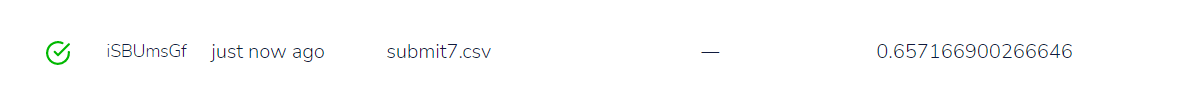

Полиномиальная регрессия: 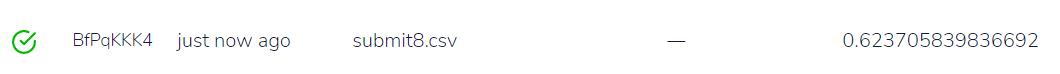

Адаптивный бустинг: 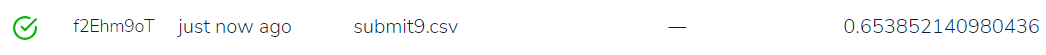